In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import random
from numba import jit
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.metrics import mean_squared_error
#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
def generateSpins(N):
    return np.random.choice([-1,1],size=N)

def generateS(J):
    return np.where(J==0,J,1)

def getEnergy(s, J):
    ss = (np.dot(S,s) + np.dot(s,S))*s
    E = -J@np.sum(ss)
    return E

def getDeltaE(i, s, J):
    q = 2*np.dot(s,J[i])
    return s[i]*q

def update(s, N, J, beta):
    i = np.random.choice(N)
    deltaE = getDeltaE(i, s, J)
    if deltaE < 0:
        s[i] *= -1
    elif np.random.random() < np.exp(-beta*deltaE):
        s[i] *= -1
    return s

In [40]:
# a matrix of random uniform connections J[ij]

N = 6
J_raw = np.zeros((N,N))
for i in range (N):   
    for j in range(i,N):
            J_raw[i][j] = J_raw[j][i] = np.random.choice([0,np.random.uniform()],p=[0.6,0.4])
            J_raw[i][i] = 0
np.around(J_raw,decimals = 3)

array([[0.   , 0.   , 0.686, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.474, 0.983],
       [0.686, 0.   , 0.   , 0.456, 0.   , 0.777],
       [0.   , 0.   , 0.456, 0.   , 0.   , 0.   ],
       [0.   , 0.474, 0.   , 0.   , 0.   , 0.488],
       [0.   , 0.983, 0.777, 0.   , 0.488, 0.   ]])

Weight couplings: by population:
$$
\tilde{J_{ij}} = \frac{J_{ij} P_j}{\sum_{k \in V_i}  P_k}
$$ 

In [41]:
P = np.around(np.random.uniform(1,10,size = N))
P

array([7., 2., 6., 9., 4., 5.])

In [42]:
def pop_weight(M,pop):
    M_new = np.copy(M)
    for i in range(len(M)):
        for j in range (len(M)):
            pop_sum= 0
            for k in range(len(M)):
                if M_new[i][k]!=0:
                    pop_sum+=pop[k]
            if i!=j:
                M_new[i][j] = pop[j]*M_new[i][j]/pop_sum
    return M_new

J = pop_weight(J_raw,P)
np.around(J,2)


array([[0.  , 0.  , 0.69, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.21, 0.55],
       [0.23, 0.  , 0.  , 0.2 , 0.  , 0.19],
       [0.  , 0.  , 0.46, 0.  , 0.  , 0.  ],
       [0.  , 0.14, 0.  , 0.  , 0.  , 0.35],
       [0.  , 0.16, 0.39, 0.  , 0.16, 0.  ]])

In [43]:
M = 300
beta = 2
S = generateS(J)
iterations = 200
configs = []

for i in range(M):
    sys = generateSpins(N)

    for n in range(iterations):
        sys = update(sys, N, J, beta)
    configs.append(sys)


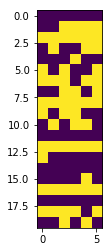

In [44]:
plt.imshow(configs[0:20])
plt.show()


In [45]:
df = pd.DataFrame(configs)
df.head()

,0,1,2,3,4,5
0,-1,-1,-1,-1,-1,-1
1,-1,-1,1,1,1,1
2,1,1,1,1,1,1
3,-1,1,-1,-1,1,1
4,-1,-1,-1,1,-1,-1


In [46]:
''' Convert df to numpy'''
df = pd.DataFrame(df).to_numpy()
type(df)

numpy.ndarray

In [47]:
''' Compute the obsereved correlation matrix C
C[ij] = (n-(M-n))/M = 2n/M -1, 
M is number of configurations and n is number of configs where s_i and s_j same

'''
def Corr(df,M):
    C = np.zeros((N,N))
    ct = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            same = 0
            i_samp = df[0:,i]
            j_samp = df[0:,j]
            for k in range(M):
                if i_samp[k] == j_samp[k]:
                    same +=1            
            c_ij = 2*same/M - 1
            C[i][j] = c_ij            
    return C
C = Corr(df,M)
np.around(C,decimals = 2)

array([[1.  , 0.43, 0.71, 0.53, 0.3 , 0.54],
       [0.43, 1.  , 0.49, 0.37, 0.55, 0.71],
       [0.71, 0.49, 1.  , 0.61, 0.39, 0.63],
       [0.53, 0.37, 0.61, 1.  , 0.24, 0.47],
       [0.3 , 0.55, 0.39, 0.24, 1.  , 0.57],
       [0.54, 0.71, 0.63, 0.47, 0.57, 1.  ]])

In [24]:
np.around(np.corrcoef(df.T),2)

array([[ 1.  ,  0.07,  0.85,  0.55,  0.03,  0.07],
       [ 0.07,  1.  ,  0.04,  0.02, -0.03,  0.95],
       [ 0.85,  0.04,  1.  ,  0.61,  0.04,  0.04],
       [ 0.55,  0.02,  0.61,  1.  ,  0.07,  0.  ],
       [ 0.03, -0.03,  0.04,  0.07,  1.  , -0.02],
       [ 0.07,  0.95,  0.04,  0.  , -0.02,  1.  ]])

# Inverse Ising

at each step update $J_{ij}$ to $J_{ij}$ + $\Delta J_{ij}$, where
\begin{equation}
\Delta J_{ij} = \alpha (C_{ij0}-C_{ij}(t))
\end{equation}

and

\begin{equation}
C_{ij}(t) = (1-\epsilon)C_{ij}(t-1)+\epsilon C_{ij}(t)
\end{equation}
% \frac{1}{M} \sum_{k = 1}^{M} s_i^k s_j^k

In [54]:
def inv_ising(C, guess_J,M, alpha,epsilon, tol = 0.05,beta = 2,steps = 200, max_steps = 1000):
    '''
    input:
    C = target corr matrix
    guess_J initial guess for J
    M number of ising configurations at each step
    alpha = gradient value
    epsilon = weight of prev observations
    steps = steps of the ising model
    
    '''
    eps = 1
    error =  []
    N = len(guess_J)
    s = 0
    while eps == 1:
        s+=1
        if s>max_steps:
            break
        else:
            # make configurations
            configs_train = []
            for i in range(M):
                sys = generateSpins(N)

                for n in range(iterations):
                    sys = update(sys, N, guess_J, beta)
                configs_train.append(sys)

             
            df_obs = pd.DataFrame(configs_train) 
            df_obs = pd.DataFrame(df_obs).to_numpy()  
            # calculate current C
            C_obs =Corr(df_obs,M)

            if s>1: 
                
                #C_obs = (1-epsilon)*C_prev + epsilon*(1/M)*np.sum(i_samp*j_samp)
                C_obs = (1-epsilon)*C_prev+epsilon*C_obs
                

                    
            delta =  C - C_obs
            error.append(np.average(np.abs(delta)))
            '''
            if all( np.abs(c) <=tol for c in delta.flatten() ):
                    eps = 0
                    print("converged")
            '''
            if np.average(np.abs(delta)) <=tol:
                    eps = 0
                    print("converged")
                    break
            delta =  pop_weight(delta,P)
            guess_J+=alpha*delta
            
            guess_J = guess_J.clip(min=0)
            
            C_prev = C_obs
    return guess_J, C_obs,error

In [55]:
epsilon = 0.05
alpha = 10**(-2)

In [56]:
guess_J = np.copy(C)
#guess_J = pop_weight(guess_J,P)
np.around(guess_J,2)

array([[1.  , 0.43, 0.71, 0.53, 0.3 , 0.54],
       [0.43, 1.  , 0.49, 0.37, 0.55, 0.71],
       [0.71, 0.49, 1.  , 0.61, 0.39, 0.63],
       [0.53, 0.37, 0.61, 1.  , 0.24, 0.47],
       [0.3 , 0.55, 0.39, 0.24, 1.  , 0.57],
       [0.54, 0.71, 0.63, 0.47, 0.57, 1.  ]])

In [57]:
# prints number of steps
J_est, C_est ,error= inv_ising(C, guess_J,M, alpha,epsilon,tol = 0.001,max_steps = 800)

In [58]:
np.around(J_est, decimals = 2)

array([[1.  , 0.13, 0.25, 0.01, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.12, 0.35],
       [0.2 , 0.22, 1.  , 0.04, 0.  , 0.17],
       [0.01, 0.08, 0.19, 1.  , 0.  , 0.  ],
       [0.  , 0.32, 0.  , 0.  , 1.  , 0.02],
       [0.  , 0.55, 0.1 , 0.  , 0.12, 1.  ]])

In [59]:
np.around(J, decimals = 2)

array([[0.  , 0.  , 0.69, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.21, 0.55],
       [0.23, 0.  , 0.  , 0.2 , 0.  , 0.19],
       [0.  , 0.  , 0.46, 0.  , 0.  , 0.  ],
       [0.  , 0.14, 0.  , 0.  , 0.  , 0.35],
       [0.  , 0.16, 0.39, 0.  , 0.16, 0.  ]])

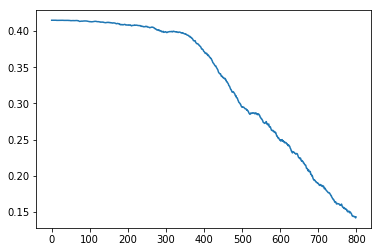

In [60]:

plt.plot(error)
plt.show()


In [61]:
J_est = J_est - np.identity(N)

In [62]:
J = np.nan_to_num(J)

In [63]:
mean_squared_error(J_est,J)

0.021697618142376158

In [64]:
mean_squared_error(C_est,C)

0.031684674551551606

--------------------------------------------
# Plot network


In [ ]:
labels =  list(range(N))

G = nx.from_numpy_matrix(J)

G = nx.relabel_nodes(G,lambda x: labels[x])

G.edges(data=True)


In [79]:
def plot_network(connections):
    labels =  list(range(len(connections)))
    G = nx.from_numpy_matrix(connections)
    G = nx.relabel_nodes(G,lambda x: labels[x])
    G.edges(data=True)

    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #positions
    positions=nx.circular_layout(G)    
    #Figure size
    plt.figure(figsize=(8,8))
    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#FEB335',
                            node_size=[v**2 * 30 for v in P])    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,width = 4, edge_color ='#0699e5')    
    # displays the graph without axis
    
    plt.axis('off')  
  
    plt.show() 

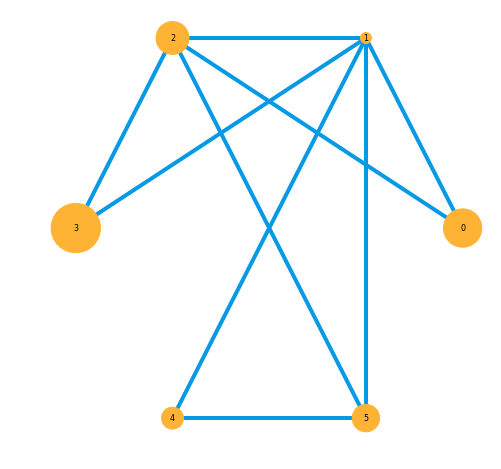

In [80]:
plot_network(np.where(J_est>0.05,J_est,0))

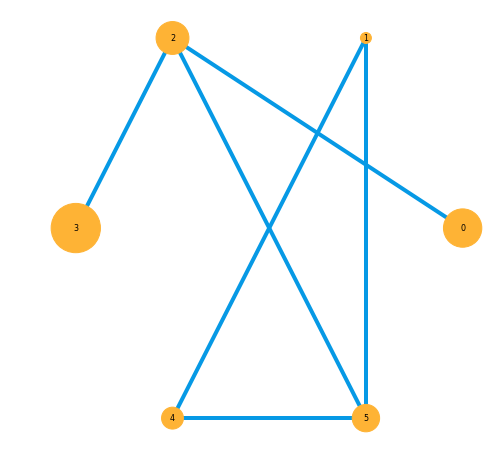

In [78]:
plot_network(J)